In [1]:
import torch
import pandas as pd
from transformers import AutoModelForMaskedLM, AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import numpy as np
# using the code in dim_reduction.py
from dim_reduction import recude_dim
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

project_path = '/home/mila/s/sahar.omidishayegan/scratch/iran/nlp_course/project/'
runs_folder = project_path + 'runs/'
if not os.path.exists(runs_folder):
    os.makedirs(runs_folder)

data_path = project_path + 'data/'
labeled_data_path = data_path+'df_monarchy_and_gov_top_25_rsrc_tweets.csv'

# pick the models you want to work with
model_names = [
    'Final_NoCL_fullData',
    'Final_WithCL_fullData',
    'bert-fa-zwnj-base'
]
model_paths= [
    runs_folder,
    runs_folder,
    "HooshvareLab/"
]


/home/mila/s/sahar.omidishayegan/projects/GAT_LP/gat_env/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load the pre-trained model and tokenizer from scratch directory
def plot_2d(embeddings_2d, labels, data_range, title = None, model_name=None):
    """
    :param embeddings_2d: the embeddings reduced to 2D
    :param labels: the labels of the clusters
    :param title: the title of the plot
    :param model_name: the name of the model
    :return: None
    """
    plt.clf()
    plt.figure(figsize=(10,10))
    unique_labels = set(labels)
    n_clusters_= len(unique_labels)
    colors = plt.cm.rainbow(np.linspace(0, 1, n_clusters_))
    if -1 in unique_labels:
        plt.scatter(embeddings_2d[labels == -1, 0], embeddings_2d[labels == -1, 1], color='k', s=10, label='Noise', alpha=0.3)
    for cluster, color in zip(range(n_clusters_), colors):
        mask = labels == cluster
        plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], label=f'Cluster {cluster}', color=color, edgecolors='k', s=50, alpha=0.3)
    plt.xlim(data_range[0])
    plt.ylim(data_range[1])
    plt.title(f'Visualization of text embeddings \nNumber of clusters: {n_clusters_}\n{title}')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend()
    print('/home/mila/s/sahar.omidishayegan/projects/nlp_course/project/final_plots/'+model_name+'-'+title+'.png')
    plt.savefig('/home/mila/s/sahar.omidishayegan/projects/nlp_course/project/final_plots/'+model_name+'-'+title+'.png')
    plt.show()


In [3]:
# prepare the data
df = pd.read_csv(labeled_data_path)
df = df[df['weak_label'] !=3]

tids = df['tid'].tolist()
labels = df['weak_label'].tolist()

X_train, X_test, y_train, y_test = train_test_split(tids, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42)

df = df[df['tid'].isin(X_test)]

def aggregate_group(group):
    aggregated_data = group.head(4)  # Take the first 10 entries of each group
    json_joined = ''.join(aggregated_data['json'])  # Join json data
    first_row = aggregated_data.iloc[0].copy()
    first_row['json'] = json_joined
    
    return first_row

df = df.groupby('id').apply(aggregate_group).reset_index(drop=True)
print('Size of the dataframe:', df.shape)

labels = df['weak_label'].to_list()
labels = [x - 1 for x in labels]

Size of the dataframe: (690, 9)


In [4]:
model_name = model_names[2]
model_path = model_paths[2]+model_name
print('Model path:',model_path)

if model_name == 'bert-fa-zwnj-base':
    model = AutoModelForMaskedLM.from_pretrained(model_path)
    tokenizer = AutoTokenizer.from_pretrained(model_path)
else:
    model = AutoModelForMaskedLM.from_pretrained(model_path+'/model')
    tokenizer = AutoTokenizer.from_pretrained(model_path+'/model')

model.config.output_hidden_states = True
model.eval()

def encode_tweet(tokenized_input):
    # encoded_input = tokenizer(tweet, return_tensors='pt',padding=True,truncation=True,max_length=128).to(device)
    last_hidden_states = model(**tokenized_input).hidden_states[-1]
    del tokenized_input
    sentence_embedding = last_hidden_states.mean(dim=1)
    del last_hidden_states
    return sentence_embedding

def tokenize(tweet):
    return tokenizer(tweet, return_tensors='pt',padding=True,truncation=True,max_length=128).to(device)

l = []
for i in range(len(df)):
    tweet = df['json'].iloc[i]
    model = model.to(device)
    encoded_input = encode_tweet(tokenize(tweet))
    encoded_input = encoded_input.squeeze(0).cpu().detach().numpy()
    l.append(encoded_input)
print('Length of embeddings:',len(l[0]))

del model
del tokenizer

torch.cuda.empty_cache()
print('Emptied cuda cache')

encoded_tweets = torch.Tensor(l)
encoded_tweets = encoded_tweets.detach().cpu().numpy()

Model path: HooshvareLab/bert-fa-zwnj-base
Length of embeddings: 768
Emptied cuda cache


/home/mila/s/sahar.omidishayegan/projects/GAT_LP/gat_env/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)


In [11]:
REDUCTION_METHOD = 'umap' # 'tsne' or 'umap'
embeddings_2d = recude_dim(embeddings=encoded_tweets ,n_components= 2, method=REDUCTION_METHOD)

(690, 2)


In [14]:
clustering_model = KMeans(n_clusters=2, random_state=42)
reduction = ''

CLUSTER_BEFORE_REDUCTION = True # True or False
if CLUSTER_BEFORE_REDUCTION:
    clustering_labels = clustering_model.fit_predict(encoded_tweets)
    print('Clustered before reduction')
    reduction = 'before'
else:
    clustering_labels = clustering_model.fit_predict(embeddings_2d)
    print('Clustered after reduction')
    reduction = 'after'
print('clustered')

Clustered before reduction
clustered


/home/mila/s/sahar.omidishayegan/projects/nlp_course/project/final_plots/bert-fa-zwnj-base-before-umap-True Labels.png


<Figure size 640x480 with 0 Axes>

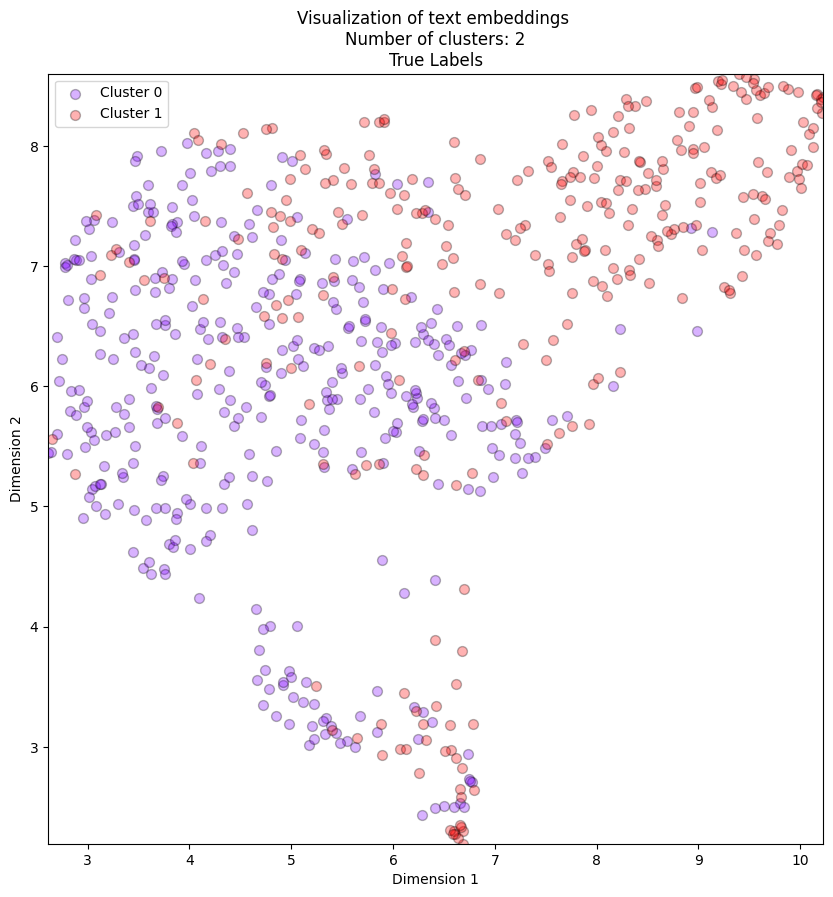

/home/mila/s/sahar.omidishayegan/projects/nlp_course/project/final_plots/bert-fa-zwnj-base-before-umap-Clustering Labels.png


<Figure size 640x480 with 0 Axes>

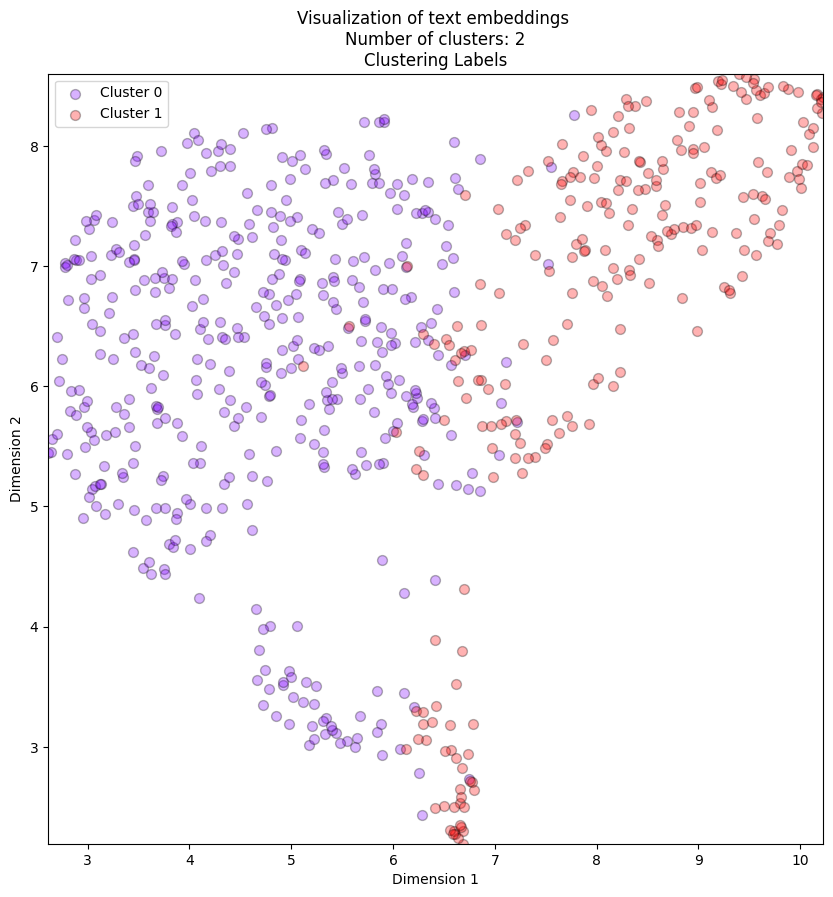

ARS for bert-fa-zwnj-base is 0.2891531262702531
Accuracy for bert-fa-zwnj-base is 0.23043478260869565
Flipped accuracy for bert-fa-zwnj-base is 0.7695652173913043


In [15]:
# plot the clusters
data_range = ((embeddings_2d[:,0].min(), embeddings_2d[:,0].max()), (embeddings_2d[:,1].min(), embeddings_2d[:,1].max()))  
plot_2d(embeddings_2d, np.array(labels), data_range=data_range, title='True Labels', model_name=model_name+'-'+reduction+'-'+REDUCTION_METHOD ) #fix tje path
plot_2d(embeddings_2d, clustering_labels, data_range=data_range, title= 'Clustering Labels', model_name=model_name+'-'+reduction+'-'+REDUCTION_METHOD) #fix the path

# evaluate the clustering
# compare the clustering labels with the actual labels
from sklearn.metrics import adjusted_rand_score
print(f"ARS for {model_name} is {adjusted_rand_score(labels, clustering_labels)}")

# accuracy
from sklearn.metrics import accuracy_score
labels = [0 if x == 1 else 1 for x in labels]
print(f"Accuracy for {model_name} is {accuracy_score(labels, clustering_labels)}")
labels = [0 if x == 1 else 1 for x in labels]
print(f"Flipped accuracy for {model_name} is {accuracy_score(labels, clustering_labels)}")